# This is a sample Jupyter Notebook to demo the connection of this to the overall environment of this baseball analysis system built through docker compose

In [9]:
import pandas as pd
import psycopg2
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

In [4]:
def test_postgres_connection():
    try:
        # Define connection parameters
        conn = psycopg2.connect(
            dbname="MLB_DATA",
            user="user",
            password="password",
            host="postgres",
            port="5432"
        )
        
        # Create a cursor and test the connection
        cur = conn.cursor()
        cur.execute("SELECT 1;")
        cur.fetchone()
        
        print("Connected to PostgreSQL successfully.")
        return 'success'  # Return the connection object if successful

    except psycopg2.Error as e:
        print("Error connecting to PostgreSQL:", e)
        raise  # raise error for error

### I will test a Connection to The Database First

In [5]:
test_postgres_connection()

Connected to PostgreSQL successfully.


'success'

In [6]:
# Function to get Pitcher Info
def get_all_pitches_info(pitcher_id: int):
    try:
        # Define connection parameters
        conn = psycopg2.connect(
            dbname="MLB_DATA",
            user="user",
            password="password",
            host="postgres",
            port="5432"
        )
        cur = conn.cursor()

        df = pd.read_sql(f"SELECT * FROM PITCH_INFO_FACT WHERE PITCHER_ID = {pitcher_id};", conn )

        return df 

    except psycopg2.Error as e:
        print("Error connecting to PostgreSQL:", e)
        raise  # raise error for error

In [7]:
nathan_eovaldi_pitches = get_all_pitches_info(543135)

print(nathan_eovaldi_pitches.head(15))
print(nathan_eovaldi_pitches.info())

nathan_eovaldi_pitches['pitch_name'].unique()

/tmp/ipykernel_158/2849660462.py:14: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(f"SELECT * FROM PITCH_INFO_FACT WHERE PITCHER_ID = {pitcher_id};", conn )


                    pitch_id  pitcher_id  batter_id             hit_id  \
0   745605543135671732691Bot      543135     671732               None   
1   745605543135671732681Bot      543135     671732               None   
2   745605543135671732671Bot      543135     671732               None   
3   745605543135671732661Bot      543135     671732               None   
4   745605543135671732651Bot      543135     671732               None   
5   745605543135671732641Bot      543135     671732               None   
6   745605543135671732631Bot      543135     671732               None   
7   745605543135671732621Bot      543135     671732               None   
8   745605543135671732611Bot      543135     671732               None   
9   745605543135667670751Bot      543135     667670               None   
10  745605543135667670741Bot      543135     667670               None   
11  745605543135667670731Bot      543135     667670               None   
12  745605543135667670721Bot      5431

array(['Split-Finger', '4-Seam Fastball', 'Cutter', 'Curveball', 'Slider',
       'Sinker', 'Pitch Out', None, 'Changeup', 'Intentional Ball'],
      dtype=object)

Number of null values in pitch_name: 15
Number of null values in pitch_name: 0
['Split-Finger' '4-Seam Fastball' 'Cutter' 'Curveball' 'Slider' 'Sinker'
 'Pitch Out' 'Changeup' 'Intentional Ball']
pitch_name
4-Seam Fastball     6717
Split-Finger        3344
Cutter              2886
Curveball           2278
Slider              1458
Changeup              72
Sinker                18
Intentional Ball       5
Pitch Out              3
Name: count, dtype: int64


/tmp/ipykernel_158/400082061.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pitch_counts, x='Pitch Type', y='Count', palette='viridis')


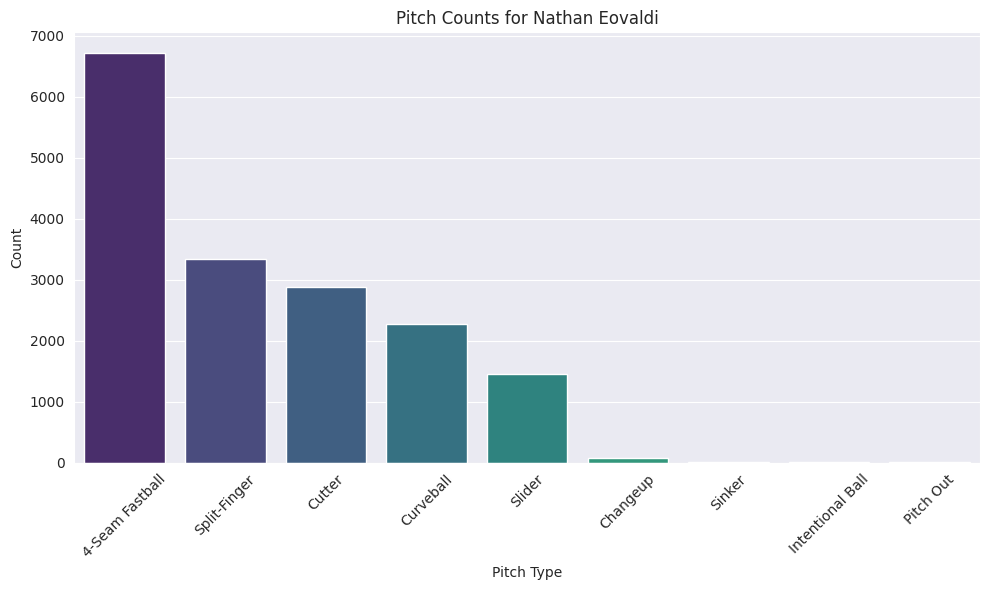

In [8]:
null_count = nathan_eovaldi_pitches['pitch_name'].isnull().sum()
print(f'Number of null values in pitch_name: {null_count}')


nathan_eovaldi_pitches = nathan_eovaldi_pitches.dropna(subset=['pitch_name'])

null_count = nathan_eovaldi_pitches['pitch_name'].isnull().sum()
print(f'Number of null values in pitch_name: {null_count}')


print(nathan_eovaldi_pitches['pitch_name'].unique())
pitch_numbers = nathan_eovaldi_pitches['pitch_name'].value_counts()
print(pitch_numbers)

# Convert Series to DataFrame
pitch_counts = pitch_numbers.reset_index()
pitch_counts.columns = ['Pitch Type', 'Count']  # Rename columns for clarity

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=pitch_counts, x='Pitch Type', y='Count', palette='viridis')
plt.title('Pitch Counts for Nathan Eovaldi')
plt.xlabel('Pitch Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [19]:
def get_min_games_played_in_season(season=2025):
    query = f"""
WITH num_home_games AS (
    SELECT home_team, COUNT(*) AS num_games
    FROM GAME_INFO_DIM
    WHERE game_year = {season} AND game_type = 'R'
    GROUP BY home_team
),
num_away_games AS (
    SELECT away_team, COUNT(*) AS num_games
    FROM GAME_INFO_DIM
    WHERE game_year = {season} AND game_type = 'R'
    GROUP BY away_team
),
total_games_played AS (
    SELECT
        COALESCE(home.home_team, away.away_team) AS team,
        COALESCE(home.num_games, 0) + COALESCE(away.num_games, 0) AS total_games
    FROM num_home_games home
    FULL JOIN num_away_games away ON away.away_team = home.home_team
)

SELECT MIN(total_games) total_games
FROM total_games_played;
"""
    try:
        # Define connection parameters
        conn = psycopg2.connect(
            dbname="MLB_DATA",
            user="user",
            password="password",
            host="postgres",
            port="5432"
        )

        cursor = conn.cursor()

        cursor.execute(query)
        num_games = cursor.fetchone()[0]


        return num_games

    except psycopg2.Error as e:
        print("Error connecting to PostgreSQL:", e)
        raise  # raise error for error


In [20]:
get_min_games_played_in_season(2025)

7

In [21]:
def get_mlb_ops_leaders(season=2025, num_games=get_min_games_played_in_season(season=2025)):
    query = f"""
WITH other_baseball_stats AS (
    SELECT * FROM BATTER_EXTRA_STATS
    WHERE GAME_YEAR = {season}
),
batting_stats AS (
    SELECT
        batter.HITTER_ID,
        SUM(CASE WHEN play.events IN ('home_run', 'triple', 'double', 'single') THEN 1 ELSE 0 END) AS hit_count,
        SUM(CASE WHEN play.events IN ('home_run', 'triple', 'double', 'single', 'double_play', 'field_error', 'fielders_choice', 'fielders_choice_out', 'field_out', 'force_out', 'grounded_into_double_play', 'strikeout', 'strikeout_double_play', 'triple_play') THEN 1 ELSE 0 END) AS total_ab,
        SUM(CASE WHEN play.events IN ('home_run', 'triple', 'double', 'single', 'walk', 'hit_by_pitch') THEN 1 ELSE 0 END) AS num_OBP,
        SUM(CASE WHEN play.events IN ('sac_fly', 'sac_fly_double_play') THEN 1 ELSE 0 END) AS SF,
        SUM(CASE WHEN play.events IN ('walk', 'hit_by_pitch') THEN 1 ELSE 0 END) AS walks,
        SUM(CASE WHEN play.events IN ('single') THEN 1 ELSE 0 END) AS num_singles,
        SUM(CASE WHEN play.events IN ('double') THEN 1 ELSE 0 END) AS num_doubles,
        SUM(CASE WHEN play.events IN ('triple') THEN 1 ELSE 0 END) AS num_triples,
        SUM(CASE WHEN play.events IN ('home_run') THEN 1 ELSE 0 END) AS num_hrs,
        SUM(CASE WHEN play.events IS NOT NULL THEN 1 ELSE 0 END) as num_pa
    FROM PLAY_INFO_DIM play
    LEFT JOIN PITCH_INFO_FACT fact ON fact.PLAY_ID = play.PLAY_ID
    LEFT JOIN HITTER_INFO_DIM batter ON batter.HITTER_ID = fact.BATTER_ID
    LEFT JOIN GAME_INFO_DIM game ON game.GAME_PK = fact.GAME_ID
    WHERE game.game_type = 'R' AND game.game_year = {season}
    GROUP BY batter.HITTER_ID
),
latest_team AS (
    SELECT
        fact.BATTER_ID,
        fact.HITTER_TEAM AS most_recent_team,
        ROW_NUMBER() OVER (PARTITION BY fact.BATTER_ID ORDER BY game.game_date DESC) AS rn
    FROM PITCH_INFO_FACT fact
    LEFT JOIN GAME_INFO_DIM game ON game.GAME_PK = fact.GAME_ID
    WHERE game.game_year = {season}
),
stats_table AS (
    SELECT
        batter.HITTER_NAME,
        stats.hit_count,
        stats.total_ab,
        stats.walks,
        latest.most_recent_team,
        stats.num_pa,
        other.NUM_INTENT_WALKS,
        other.NUM_RBIS,
        other.WAR,
        stats.num_HRs,
        CASE
            WHEN stats.total_ab > 0 THEN ROUND(CAST((1 * stats.num_singles + 2 * stats.num_doubles + 3 * stats.num_triples + 4 * num_hrs) AS DECIMAL) / CAST(stats.total_ab AS DECIMAL), 4)
            ELSE NULL
        END AS SLG,
        CASE
            WHEN stats.total_ab > 0 THEN ROUND((CAST(stats.hit_count AS DECIMAL) / CAST(stats.total_ab AS DECIMAL)), 4)
            ELSE NULL
        END AS BA,
        CASE
            WHEN (stats.total_ab + stats.walks + stats.SF + other.NUM_INTENT_WALKS) > 0 THEN ROUND(((CAST(num_OBP AS DECIMAL) + other.NUM_INTENT_WALKS) / (stats.total_ab + stats.walks + stats.SF + other.NUM_INTENT_WALKS)), 4)
            ELSE NULL
        END AS OBP
    FROM batting_stats stats
    LEFT JOIN HITTER_INFO_DIM batter ON batter.HITTER_ID = stats.HITTER_ID
    LEFT JOIN latest_team latest ON latest.BATTER_ID = stats.HITTER_ID AND latest.rn = 1
    LEFT JOIN other_baseball_stats other ON other.HITTER_ID = batter.HITTER_ID
    WHERE stats.num_pa > {num_games} * 3.1 AND other.GAME_YEAR = {season}
)
SELECT hitter_name AS "Player", most_recent_team AS "Tm", num_pa AS "PA", ba AS "BA", obp AS "OBP", slg AS "SLG", ROUND(obp + slg, 4) AS "OPS", hit_count AS "H", num_HRs AS "HRs", walks AS "BB", NUM_INTENT_WALKS AS "IBB", NUM_RBIS AS "RBIs", WAR AS "WAR"
FROM stats_table
WHERE obp IS NOT NULL AND ba IS NOT NULL AND slg IS NOT NULL
ORDER BY "OPS" DESC;
"""
    try:
        # Define connection parameters
        conn = psycopg2.connect(
            dbname="MLB_DATA",
            user="user",
            password="password",
            host="postgres",
            port="5432"
        )

        df = pd.read_sql(query, conn )

        return df

    except psycopg2.Error as e:
        print("Error connecting to PostgreSQL:", e)
        raise  # raise error for error



In [25]:
ops_leaders_2025 = get_mlb_ops_leaders()

ops_leaders_2025.head(10)

ops_leaders_2024 = get_mlb_ops_leaders(season=2024,
                                       num_games=get_min_games_played_in_season(2024))

ops_leaders_2024.head(10)

/tmp/ipykernel_158/2240729349.py:81: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn )


,Player,Tm,PA,BA,OBP,SLG,OPS,H,HRs,BB,IBB,RBIs,WAR
0,Aaron Judge,NYY,684,0.3220,0.4580,0.7013,1.1593,180,58,122,20,144,11.2
1,Shohei Ohtani,LAD,721,0.3097,0.3901,0.6462,1.0363,197,54,77,10,130,9.1
2,Juan Soto,NYY,711,0.2887,0.4199,0.5704,0.9903,166,41,131,2,109,8.1
3,Bobby Witt,KC,701,0.3318,0.3893,0.5881,0.9774,211,32,56,9,109,10.4
4,Yordan Alvarez,HOU,617,0.3085,0.3918,0.5681,0.9599,170,35,62,16,86,5.3
5,Vladimir Guerrero,TOR,685,0.3231,0.3960,0.5438,0.9398,199,30,65,12,103,5.4
6,Ketel Marte,AZ,576,0.2917,0.3722,0.5595,0.9317,147,36,63,7,95,6.3
7,Brent Rooker,OAK,611,0.2930,0.3648,0.5623,0.9271,160,39,60,4,112,5.1
8,Marcell Ozuna,ATL,687,0.3020,0.3785,0.5462,0.9247,183,39,75,2,104,4.7
9,Bryce Harper,PHI,620,0.2855,0.3730,0.5255,0.8985,157,30,67,11,87,5.2


In [29]:
print(datetime.now().strftime("%Y-%m-%d %H:%M:%S"), "UTC")
ops_leaders_2025.head(10)

2025-04-05 18:19:04 UTC


,Player,Tm,PA,BA,OBP,SLG,OPS,H,HRs,BB,IBB,RBIs,WAR
0,Wilyer Abreu,BOS,28,0.5000,0.6207,1.0000,1.6207,11,3,6,1,8,0.8
1,Aaron Judge,NYY,32,0.3793,0.4545,1.1034,1.5579,11,6,3,1,17,1.0
2,Iván Herrera,STL,22,0.4000,0.4545,1.1000,1.5545,8,4,2,0,11,0.7
3,José Ramírez,CLE,25,0.3810,0.4400,1.0476,1.4876,8,4,3,0,6,0.5
4,Kristian Campbell,BOS,33,0.4231,0.5152,0.8077,1.3229,11,2,6,0,5,0.8
5,Maikel Garcia,KC,23,0.3810,0.4348,0.8095,1.2443,8,2,2,0,6,0.5
6,George Springer,TOR,29,0.4400,0.5172,0.7200,1.2372,11,1,4,0,5,0.6
7,Ben Rice,NYY,26,0.3500,0.4800,0.7500,1.2300,7,2,5,0,2,0.4
8,Jorge Polanco,SEA,22,0.4500,0.4762,0.7500,1.2262,9,2,1,0,8,0.3
9,Kyle Tucker,CHC,48,0.3077,0.4490,0.7436,1.1926,12,4,9,1,11,0.9


In [27]:

ops_leaders_2023 = get_mlb_ops_leaders(season=2023,
                                       num_games=get_min_games_played_in_season(2023))

ops_leaders_2023.head(10)

/tmp/ipykernel_158/2240729349.py:81: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn )


,Player,Tm,PA,BA,OBP,SLG,OPS,H,HRs,BB,IBB,RBIs,WAR
0,Shohei Ohtani,LAA,576,0.3038,0.4105,0.6539,1.0644,151,44,71,21,95,6.5
1,Corey Seager,TEX,527,0.3270,0.3899,0.6226,1.0125,156,33,44,9,96,6.3
2,Ronald Acuña,ATL,732,0.3375,0.4163,0.5956,1.0119,217,41,86,3,106,9.1
3,Matt Olson,ATL,713,0.2834,0.3894,0.6046,0.9940,172,54,100,8,139,6.6
4,Mookie Betts,LAD,690,0.3065,0.4084,0.5788,0.9872,179,39,101,3,107,7.7
5,Freddie Freeman,LAD,719,0.3312,0.4088,0.5667,0.9755,211,29,75,12,102,7.8
6,Yandy Díaz,TB,600,0.3302,0.4107,0.5229,0.9336,173,22,73,0,78,5.0
7,Juan Soto,SD,698,0.2746,0.4102,0.5194,0.9296,156,35,123,11,109,6.0
8,Marcell Ozuna,ATL,591,0.2736,0.3463,0.5585,0.9048,145,40,59,1,100,3.2
9,Bryce Harper,PHI,538,0.2932,0.4011,0.4989,0.9000,134,21,77,8,72,3.5
